# Exercise 4

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it
   
## Overview

In this exercise, you will simulate an experiment designed to measure the lifetime of an unstable particle X.  A beam of X particles is produced with a known average velocity and injected into a vacuum chamber.  Each X particle will travel some distance into the chamber before decaying at the so-called decay vertex, $r_{vtx}$.  The charged daughter particle is then detected by several tracking stations, located at various distances ($z_{stn}$) along the beam line.  Each tracking station measures the position where the track hits the station, $r_{hit}$.  By extrapolating back from the hit positions, the position of the decay vertex can be reconstructed.  Finally, the distribution of decay points, along with the known average beam velocity, can be used to estimate the mean lifetime of the X particle.

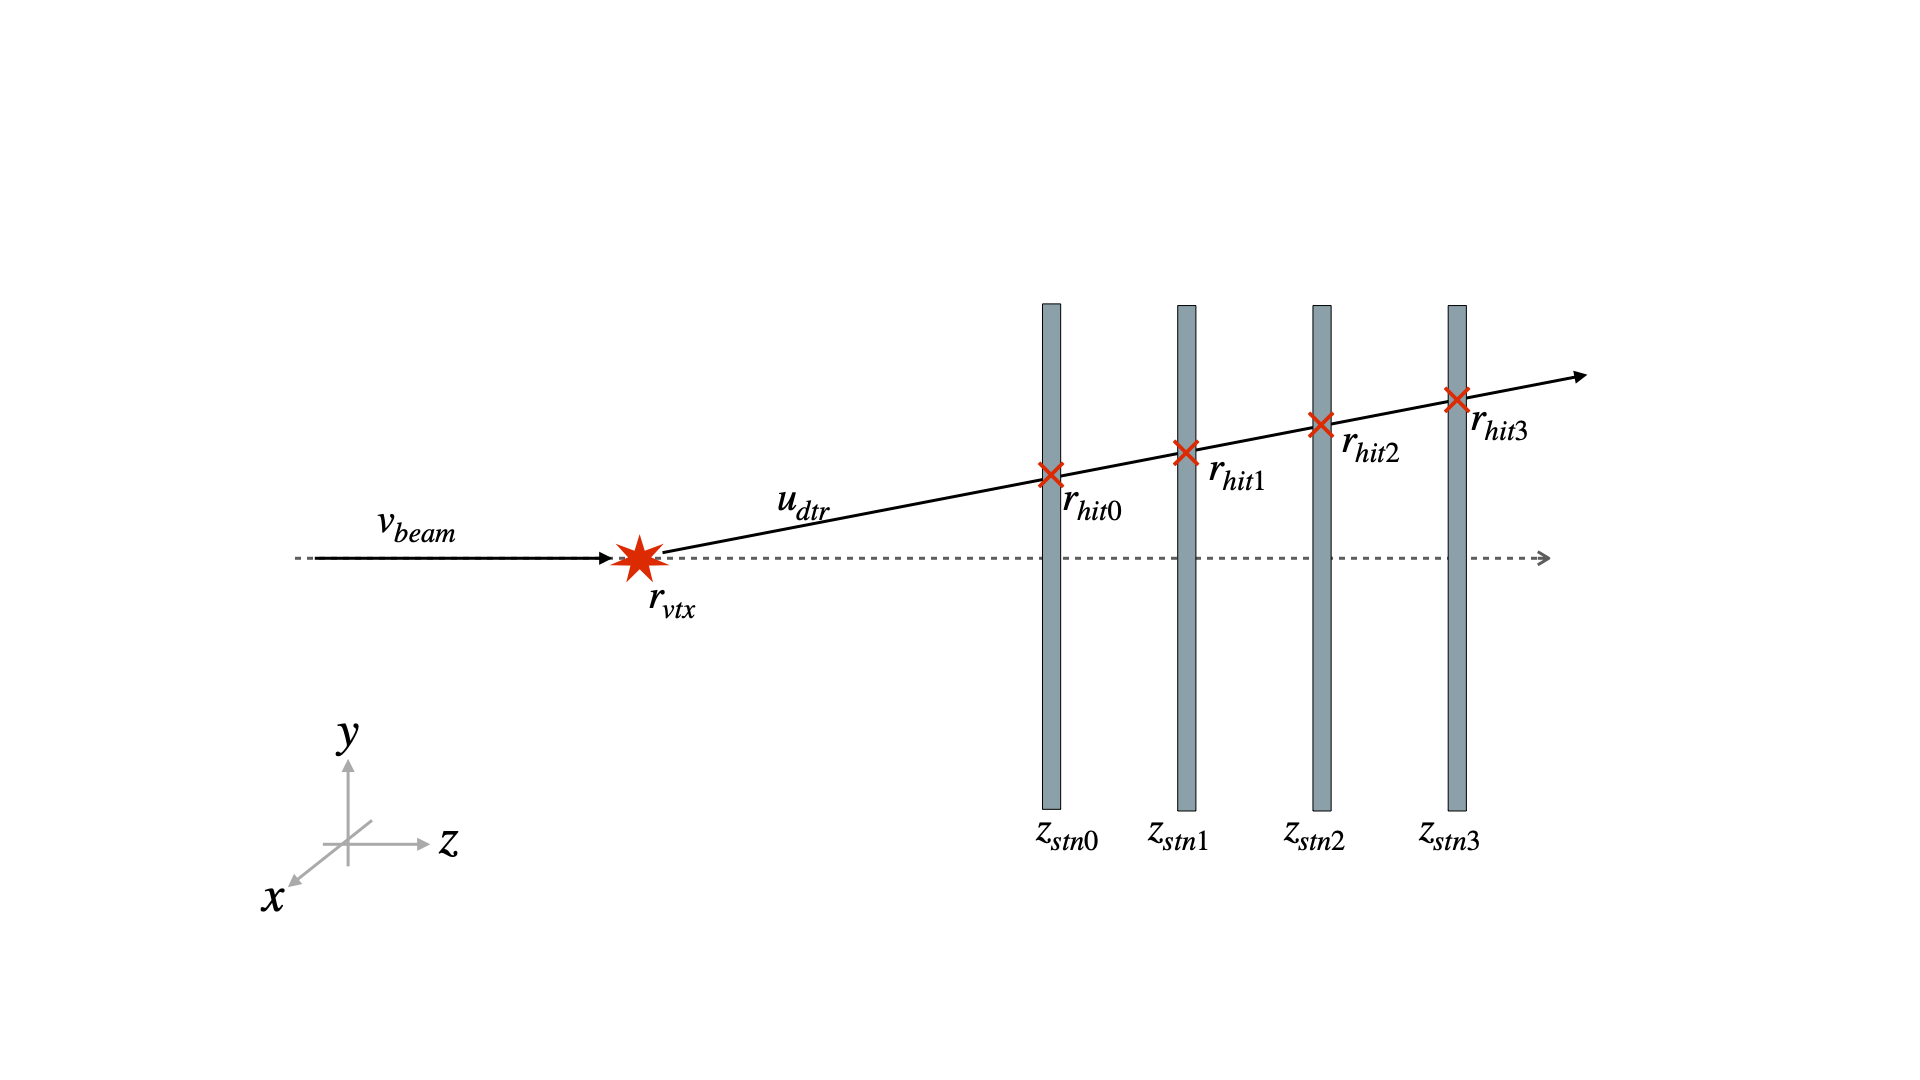

The coordinate system used below is shown in the diagram, where the beam is produced at the origin and travels in the $z$-direction.

You will use Monte Carlo methods to simulate the production, decay, and detection of particle X and it's daughter. Each part of the exercise simulates a different part of the experiment. By building up a set of functions, you will be able to simulate the full experiment.  You will then be able to simulate the experiment under different assumptions (eg. X mass, lifetime, beam parameters, tracking station positions, etc.) and make quantitative statements about how these assumptions influence the performance of the experiment.  It is strongly recommended that you use 3D vectors throughout the exercises, using numpy arrays, and numpy functions for vector algebra.

This exercise is deliberately open-ended.  A wide variety of extensions are possible, using all the topics covered in the unit.  If you are interested in exploring an extension, please discuss your plans with the unit director to ensure you efforts are well focussed.

## Part 1 - Beam Generation

First, you should simulate the production of beam particles.  Each particle in the beam will have a velocity in the z-direction, that is drawn from a normal distribution with mean $\mu_{v}$ and standard deviation $\sigma_{v}$.  The particle should decay after a time that is drawn from an exponential distribution with mean lifetime $\tau$.  Given the velocity and the decay time, the decay position in the lab frame should then be calculated.  You can assume the beam is non-relativistic.

In the cell below, write functions to simulate the beam velocity, the decay time, and the decay vertex.

In [290]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math 
from scipy import sparse, linalg, stats, special
from scipy.stats import linregress


class Beam:
    def __init__(self, mean:float, st_dev:float, tau:float, samples:int):
        self.mean = mean # mean of normal distribution
        self.st_dev = st_dev # standard deviation of normal distribution
        self.tau = tau #mean life time
        self.samples = samples # number of samples to generate
        self.decay_times = np.zeros(samples) #initialisation of variables to be stored, here is the decay times for each particle
        self.vels = np.zeros((3, samples))  #velocity of particle (vector)
        self.vertex = np.zeros((3,samples)) #vertex position (vector)
        
    def gen_beam(self):
        """
        function to samples our particle distribution. We use a normal distribution for the velocities, and an exponential distribution for the decay times.
        """
        velarray = np.zeros((3, self.samples)) 
        velarray[-1,:] = np.random.normal(self.mean, self.st_dev, self.samples) # here the neweer functions could be used, but i opted to use these due to familiarity with the syntax
        self.vels = velarray #storing our velocity values - ensuring we aren't generating new samples when we call functions (something i initially did)
        self.decay_times = np.random.exponential(self.tau, self.samples) #drawing our decay time samples from exponential distribution
        self.vertex = self.vels * self.decay_times #calculation of the vertex positions from our two previous distributions - this should also be an exponential function
    


XPART= Beam(2000, 50, 2.5e-3, int(1e6)) 

In the next cell, test your functions, and verify that they have the desired distributions.

The distributions are in good agreement with expected results, as shown by plotting against the analytic distribution


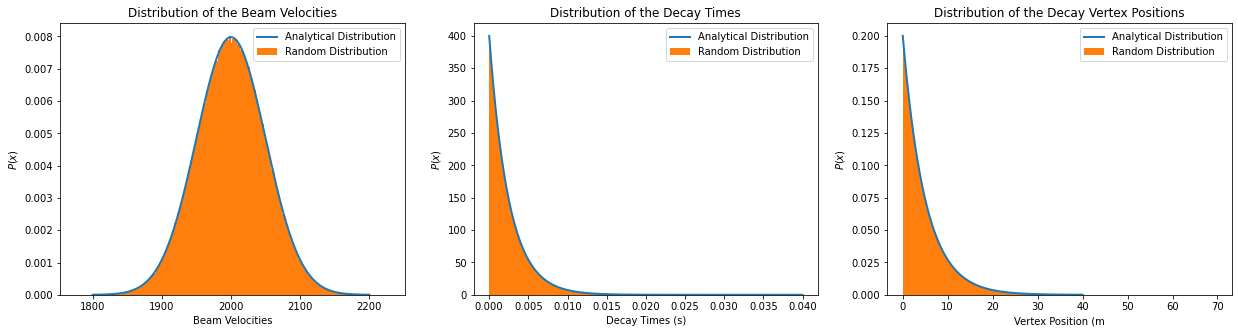

In [291]:

XPART.gen_beam()
def distribution(Beam):
    """
    Plotting functions to ensure the distributions are correct. We expect a normal distribution for the velocities and an exponential distribution 
    for the decay times and vertices.
    """

    fig, ax = plt.subplots(1, 3, figsize = (21, 5))
    xvals = np.linspace(Beam.mean - 4*Beam.st_dev, Beam.mean + 4*Beam.st_dev, np.size(Beam.vels[2, :]))

    ax[0].plot(xvals, stats.norm.pdf(xvals, Beam.mean, Beam.st_dev), label = 'Analytical Distribution', linewidth = 2) # analytic normal distribution to plot against
    ax[0].hist(Beam.vels[2,:], density = True, bins = 200, label ='Random Distribution')
    ax[0].set_xlabel('Beam Velocities')
    ax[0].set_ylabel("$P(x)$")
    ax[0].set_title("Distribution of the Beam Velocities")
    ax[0].legend(loc = 'upper right')
    
    ex = np.linspace(0,0.04, np.size(Beam.vels[2,:]))
    ey = stats.expon.pdf(ex, 0, Beam.tau) # analytic exponential distribution to plot against
    ax[1].plot(ex, ey, label = 'Analytical Distribution', linewidth = 2)
    ax[1].hist(Beam.decay_times, density = True, bins = 200, label = 'Random Distribution')
    ax[1].set_xlabel("Decay Times (s)")
    ax[1].set_ylabel("$P(x)$")
    ax[1]. set_title("Distribution of the Decay Times")
    ax[1].legend(loc = 'upper right')
    ex2 = np.linspace(0, 40, 100)
    ey2 = stats.expon.pdf(ex2, 0, Beam.tau * Beam.mean)
    ax[2].plot(ex2, ey2, label = 'Analytical Distribution', linewidth = 2)
    ax[2].hist(Beam.vertex[2, :], density = True, bins = 200, label = "Random Distribution")
    ax[2].set_xlabel('Vertex Position (m')
    ax[2].set_ylabel("$P(x)$") 
    ax[2].set_title("Distribution of the Decay Vertex Positions")
    ax[2].legend()
    plt.subplots_adjust(wspace = 0.2)
    

#need to compare with their analytical discrete distributions
distribution(XPART)
print("The distributions are in good agreement with expected results, as shown by plotting against the analytic distribution")

## Part 2 - Daughter Particle

Now simulate the direction of the decay product, which should be _isotropic_ in the rest frame of the beam particle. This is the same as generating points on the surface of a unit sphere, with uniform probability over the solid angle $d\Omega$. This can be achieved in spherical coordinates, by generating the two angles, $\phi$ and $\theta$.  These should not have uniform distributions, since the area element is given by :

$${\rm d}\Omega = \sin(\theta) {\rm d}\phi {\rm d}\theta$$

To obtain uniform probability over the sphere, you should generate $\phi$ with a uniform distribution between $0$ and $2\pi$, and $\theta$ with a distribution proportional to $\sin \theta$.

Note that the velocity of the daughter particle is not required in the base experiment, since we will assume the daughter follows a straight line track.  The direction vector we are producing here is equivalent to a unit vector in the direction of the daughter momentum, ie. $\frac{p_{dtr}}{|p_{dtr}|}$.

In the cell below, write functions which simulate the direction of the daughter particle in the rest frame of the beam particle, and the lab frame.

As for Part 1, in the next cell, test your functions and verify the desired distributions are produced.

In [292]:
class DaughterParticle(Beam): # our class for generating the daughter particle samples - we inherit the methods of Beam class
    def __init__(self, mean, st_dev, tau, samples, v_d):
        super().__init__(mean, st_dev, tau, samples) # inherit the properties of the previous Beam class
        self.v_d = v_d # daughter particle velocity 
        self.phis = np.zeros(samples) # phi samples
        self.thetas = np.zeros(samples) # theta samples
        self.unit = np.zeros((3, samples)) # unit vectors to be generated

    def angles(self):
        """
        Function to generate samples of phi and theta. We cannot just uniformly sample theta, as that would lead to clumping at the poles of our 
        spherical distribution. Instead we employ the method below.
        """
        self.phis = np.random.uniform(0, 2 * math.pi, self.samples) #uniformly drawn angles.
        x = np.random.random(self.samples) #closed half-interval, [0, 1] 
        self.thetas = np.arccos(1 - 2*x)# our distribution that is proportional to sine

    def frame_vectors(self, frame:str): 
        """
        Function to generate our unit vectors, i.e placing points on surface of a sphere isotropically. We employ the equations for a sphere.
        We also include an if statement to handle which frame we want to be in, i.e whether to perform the galilean transformation or not. 
        """
        x = np.cos(self.phis) * np.sin(self.thetas) #spherical to cartesian, easier to place points using euclidean norm. 
        y = np.sin(self.phis) * np.sin(self.thetas)
        z = np.cos(self.thetas)
        if frame == "Rest": #rest frame of the daughter partle
            norm = np.sqrt((x**2 + y**2 + z**2)) #euclidean norm
            self.unit = np.array([x/norm, y/norm, z/norm]) #our unit vector
        elif frame == "Lab": #lab frame of daughter particle
            x = x * self.v_d; y = y * self.v_d # galilean transformation to transform to lab frame
            z = self.v_d * z + self.vels[2, :] 
            norm = np.sqrt((x**2 + y**2 + z**2)) # euclidean norm 
            self.unit = np.array([x/norm, y/norm, z/norm]) #our unit vector


    #########################################
    # here is an alternate method to generate unit vectors, however i was getting some strange results in the distribution 
    #
    def frame_vectors_alt(self,  frame:str):
        """
        Function to generate our unit vectors, i.e placing points on surface of a sphere isotropically. We employ the equations for a sphere 
        and utilise a different method, it is not used further in the program, but did not feel like deleting it. 
        We also include an if statement to handle which frame we want to be in, i.e whether to perform the galilean transformation or not.
         """
        v = np.random.uniform(-1, 1, self.samples) #uniformly draw v
        x = np.cos(self.phi()) * np.sqrt(1 - v**2) # this method could be wrong here, i got it from a paper on distributing points on sphere and didn't test too much
        y = np.sin(self.phi()) * np.sqrt(1 - v**2)
        z = np.random.uniform(-1, 1, self.samples)
        if frame == "Rest":
            pass
        elif frame == "Lab":
            x = x * self.v_d; y = y * self.v_d
            z = self.v_d * z + self.b_vel()[2,:]
        norm = np.sqrt((x**2 + y**2 + z**2))
        return np.array([x/norm, y/norm, z/norm])




All plots meet our expectations. The spherical distributions are isotropic and exhibit the correct behaviour when the daughter velocityis changed. The angle distributions are of the correct form.


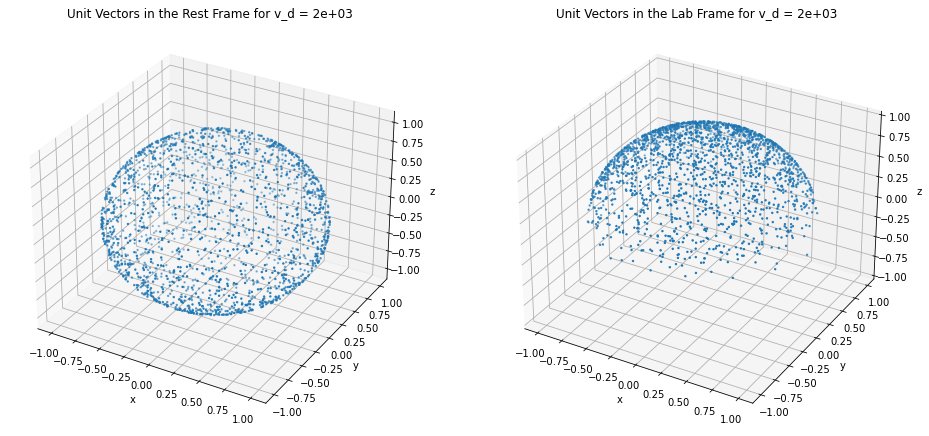

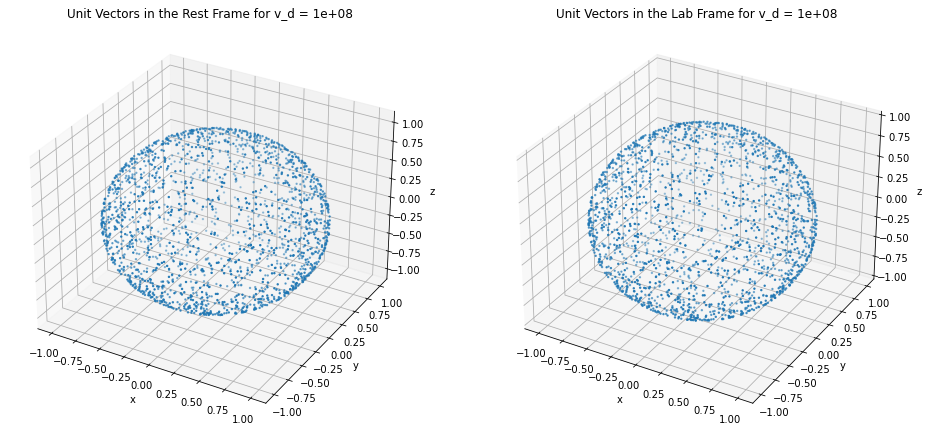

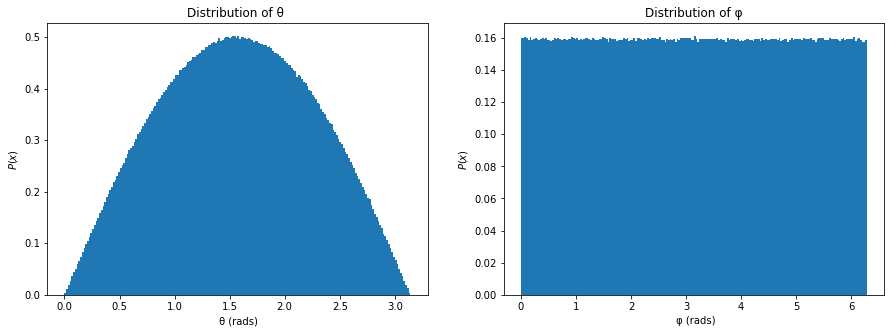

In [293]:

def frameplots(N, v_d):
    """
    Function to plot our spherical distributions using matplotlib. We use 3d plotting to fully visualise our unit vectors.
    """
    TestPart = DaughterParticle(2000, 50, 2.5e-3, N, v_d) #beam object
    TestPart.gen_beam();TestPart.angles() #generate beam properties and angles

    TestPart.frame_vectors('Rest') # generate unit vectors in rest frame
    rest = TestPart.unit

    TestPart.frame_vectors('Lab') # generate unit vectors in lab frame
    lab = TestPart.unit

    fig = plt.figure(figsize = (16, 10))
    ax = fig.add_subplot(1, 2, 1,  projection = '3d')
    

    ax.scatter(rest[0, :], rest[1, :], rest[2, :], s = 2)
    ax.set_title("Unit Vectors in the Rest Frame for v_d = %1.0e"%v_d)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(' z')

    ax = fig.add_subplot(1, 2, 2, projection = '3d')
    ax.scatter(lab[0, :], lab[1, :], lab[2, :], s = 2)
    ax.set_title('Unit Vectors in the Lab Frame for v_d = %1.0e'%v_d)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(' z')
    ax.set_zlim3d(-1, 1)
    plt.show()


def angleplots(N, v_d):
    """
    Function to verify our distributions in the angles are correct. We should expect to see the form of a sine wave for theta, and uniform 
    distribution for phi.
    """
    TestPart = DaughterParticle(2000, 50, 2.5e-3, N, v_d) #particle and beam object
    TestPart.angles() # generate samples

    
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].hist(TestPart.thetas, bins = 200, density = True)
    ax[0].set(xlabel = ' \u03B8 (rads)', ylabel = '$P(x)$', title = 'Distribution of \u03B8 ')

    ax[1].hist(TestPart.phis, bins = 200, density = True)
    ax[1].set(xlabel = ' \u03C6 (rads)', ylabel = '$P(x)$', title = 'Distribution of \u03C6')
    
    
print("All plots meet our expectations. The spherical distributions are isotropic and exhibit the correct behaviour when the daughter velocity\
is changed. The angle distributions are of the correct form.")
frameplots(2000, 2000)
frameplots(2000, 10e7) # to show the distribution remains the same for daughter velocities much larger than beam velocity
angleplots(int(10e6) , 10e7)




## Part 3 - Propagation to Tracking Stations

The next step is to propagate the daughter particle to the tracking detectors. First, it is convenient to represent the track using a set of parameters. Here, the track is a straight line, which can be represented by 5 parameters :
  * $m_x = \frac{dx}{dz}$ - gradient in the $x$ direction
  * $m_y = \frac{dy}{dz}$ - gradient in the $y$ direction
  * $c_x$ - $x$-intercept at z=0
  * $c_y$ - $y$-intercept at z=0
  * $d$ - track direction (+1 for $+z$ direction, -1 for $-z$ direction)

In the cell below, write a function which calculates the track parameters from the decay vertex and daughter direction in the lab frame.

Then write another function which takes the track parameters, and computes the intercepts of the track with the tracking stations.  The function should accept a list of $z$ coordinates (one for each tracking station) and return the position $r_{hit}$ of the hit at each station.

Note that random numbers are not required for these functions.

In [294]:
# tracking functions
class Tracking: 
    #our class to handle calculating the track parameters and hit positions (i intended this to inherit DaughterParticle but I never 
    #verified if this was okay - please let me know if it was/wasn't okay to do). In it's current form there isn't a good reason for this to be a class (i had more planned for this)
    def __init__(self, sigx, sigy):
        self.sigx = sigx #smearing standard deviation in the x-direction
        self.sigy = sigy #smearing standard deviation in the y-direction
        
    def grad_inter(self, DaughterParticle):
        """
        Function to generate the gradient and intercept for each particle, in both x and y. Returns an array of gradient (mx,my) values
        and an array of intercept coordinates for the z = 0 plane - (cx, cy, 0).
        """
        grad_arr = np.empty((DaughterParticle.samples, 2)) # initialising arrays
        inter_arr = np.empty((DaughterParticle.samples, 2))
        dz = DaughterParticle.unit[2, :] # vertex z-coordinates
        grad_X = DaughterParticle.unit[0, :] / dz# gradient in x direction
        grad_Y = DaughterParticle.unit[1, :] / dz # gradient in y direction
        grad_arr[:, 0] = grad_X # putting them in an array
        grad_arr[:, 1] = grad_Y 
        cx = grad_arr[:, 0] * DaughterParticle.vertex[2] # intercept in z = 0. x = m * z + c just rearranged
        cy = grad_arr[:, 1] * DaughterParticle.vertex[2] # y = m * z + c
        inter_arr[:, 0] = cx # putting them in array 
        inter_arr[:, 1] = cy
        return grad_arr, inter_arr 

    def track_direction(self, DaughterParticle):
        """
        Function to determine the direction of the particle in the z-direction. Returns an array of +1s and -1s, depending on z-direction
        """
        z = DaughterParticle.unit[2,:] 
        return abs(z)/z #this seemed the most efficient to me, using np.where may become convoluted. We can use this method as all my arrays share the same index.
    
    def hits(self, DaughterParticle, z):
        """
        Function to calculate the hit positions on the tracking stations. Will accept an arbitrary number of stations, 
        and returns the hit positions as each station along with the track parameters. Also filters out the vectors in negative z-direction.
        """
        stations = np.asarray(z)
        d = self.track_direction(DaughterParticle) # our track-direction array
        delta, c = self.grad_inter(DaughterParticle) # gradient and intercept arrayes
        delta = delta[d>0]; c = c[d>0] #filter the negative z-direction vectors out using boolean array indexing - specifically designed for numpy arrays
        rx = np.zeros((np.size(d[d>0]), len(z))) #ensuring the arrays are of the same size as filtered gradient and intercept arrays
        ry = np.zeros((np.size(d[d>0]), len(z)))
        for i in range(0, len(z)): # our loop to calculate hits at each tracking station. If there is a way to not make this a loop/ make it faster, please let me know in the feedback (I spent a while trying to find a way).
            rx[:, i] = delta[:, 0] * stations[i] + c[:, 0] # straight line equation x = m * z + c_x
            ry[:, i] = delta[:, 1] * stations[i] + c[:, 1]
        if np.size(rx) == 0:
            DaughterParticle.angles(); DaughterParticle.frame_vectors('Lab') #function is recursive, to handle low sample sizes.
            return self.hits(DaughterParticle, z)                            #if this was not included, there is a possibility to return None in the case of low samples, which causes an error. 
        return rx, ry, delta, c

In the next cell, test your track propagation functions. (A qualitative assessment is acceptable here).

In [305]:
# test code

mini_daught = DaughterParticle(2000, 50, 2.5e-3, 10, 10e7)
mini_track = Tracking(0.01, 0.01)


def regress(Tracking, DaughterParticle, z):
    """
    Function to verify that the hit positions are correct. We utilise scipy's linear regression function to calculate the gradient and intercept given the
    four(eight including x and y) points and z-coordinates. Would be slow for large sample sizes however, so it should not be used to reconstruct
    the vertices or decay times even though it does boast a low error. 
    """
    np.random.seed(123459) # using a seed to make my tables look neat. 
    DaughterParticle.gen_beam(); DaughterParticle.angles()
    DaughterParticle.frame_vectors('Lab') # generating our samples
    rx, ry, delta, c = Tracking.hits(DaughterParticle, z)    #calculating the hit positions
    N = np.size(delta[:,0]) 
    m_x = np.empty(N); m_y = np.empty(N)
    c_x = np.empty(N); c_y = np.empty(N)
    for i in range(N):
        m_x[i], c_x[i]= linregress(z, rx[i, :])[0:2]# linear regression function to calculate track parameters from the points. 
        m_y[i], c_y[i]= linregress(z, ry[i, :])[0:2] 

    reg_m = np.empty((N, 2)); reg_c = np.empty((N,2)) #regression gradient and intercept.
    reg_m[:, 0] = m_x; reg_m[:, 1] = m_y #filling arrays 
    reg_c[:, 0] = c_x; reg_c[:, 1] = c_y
    return delta, reg_m, reg_c, c

posis = [30, 35, 40, 45]
delta, reg_m, reg_c, c = regress(mini_track, mini_daught, posis)

###### Tables of values. the form is || Known, Generated gradient || Gradient from linear regression || Difference in the gradients||
print("{:<12} {:<12} {:<12}".format("|| Generated Gradient        ||", "Regression Gradient", "        || \u0394m    ||"))
for i in range(np.size(delta[:, 0])):
    print("||", delta[i, :], "|| ", reg_m[i, :], " || ",  abs(delta[i, :] - reg_m[i, :]),' ||') 
print("----------------")
print("{:<12} {:<8} {:<12}".format("|| Generated Intercept       ||", "Regression Intercept", "       || \u0394c   ||"))
for i in range(np.size(c[:, 0])): 
    print("||", c[i, :], "|| ", reg_c[i, :], " || ",  abs(c[i, :] - reg_c[i, :]),' ||') 


|| Generated Gradient        || Regression Gradient         || Δm    ||
|| [ 0.33690805 -2.670126  ] ||  [ 0.33690805 -2.670126  ]  ||  [1.11022302e-16 4.44089210e-16]  ||
|| [ 1.07176787 -0.43335273] ||  [ 1.07176787 -0.43335273]  ||  [0.00000000e+00 2.22044605e-16]  ||
|| [ 0.28280363 -0.3481651 ] ||  [ 0.28280363 -0.3481651 ]  ||  [5.55111512e-17 1.11022302e-16]  ||
|| [ 0.94894748 -4.80512471] ||  [ 0.94894748 -4.80512471]  ||  [1.11022302e-16 0.00000000e+00]  ||
|| [-0.45857952  0.05325329] ||  [-0.45857952  0.05325329]  ||  [2.22044605e-16 0.00000000e+00]  ||
----------------
|| Generated Intercept       || Regression Intercept        || Δc   ||
|| [ 1.05772757 -8.38289823] ||  [ 1.05772757 -8.38289823]  ||  [5.32907052e-15 5.32907052e-15]  ||
|| [ 8.63256014 -3.49044192] ||  [ 8.63256014 -3.49044192]  ||  [3.55271368e-15 1.06581410e-14]  ||
|| [ 1.96936132 -2.42451941] ||  [ 1.96936132 -2.42451941]  ||  [1.55431223e-15 3.55271368e-15]  ||
|| [  2.64966952 -13.41696228] ||  [  2.

## Part 4 - Hit Smearing

The tracking detectors are not perfect, and will measure position with some resolution.  This can be simulated by adding an offset to the true hit position, where the $x$ ($y$) offset is drawn from a normal distribution with a mean of zero and standard deviation $\sigma_{x}$ ($\sigma_{y}$), equal to the resolution of the detector in the $x$ ($y$) direction.  This process is known as smearing.

You should write a function which takes the true hit positions and smears them according to the detector resolution, to produce the reconstructed (or measure) hit positions.

In [296]:
# smearing function

def smear(Tracking, DaughterParticle, z):
    """
    Function to smear the hit positions with a resolution. Returns the smeared and true hit positions
    """
    rx, ry, delta, ct= Tracking.hits(DaughterParticle, z)
    x = np.random.normal(0, Tracking.sigx, size = (np.size(rx[:, 0]), len(z))) # normal distributions
    y = np.random.normal(0, Tracking.sigy, size = (np.size(ry[:, 0]), len(z)))
    smear_x = rx + x; smear_y = ry + y # smear the positions just by adding
    return smear_x, smear_y, rx, ry


Again, you should test your code to verify that the desire distributions are indeed produced.

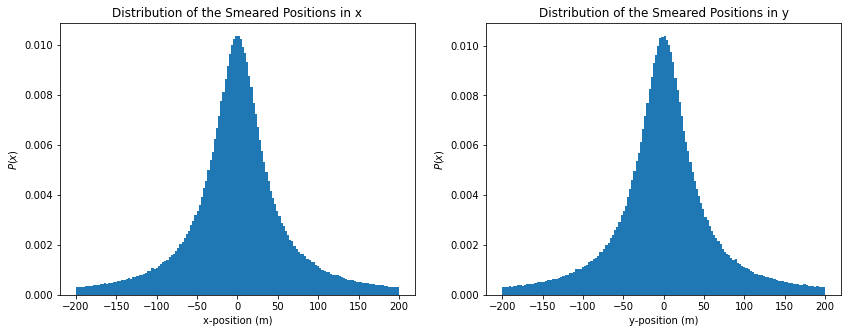

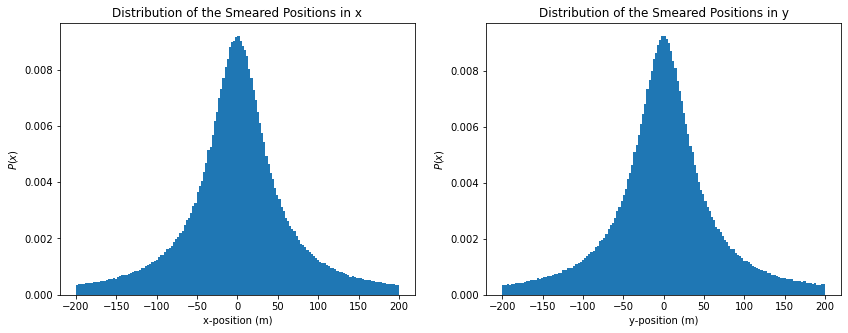

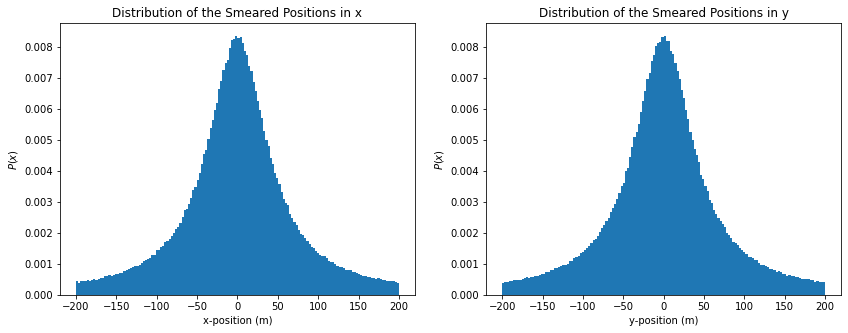

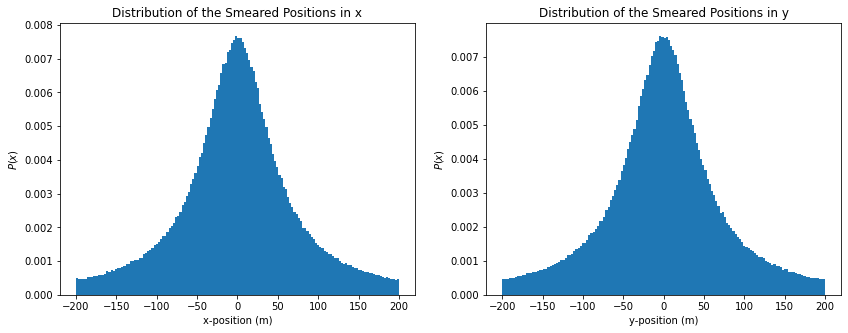

In [306]:
# test code

stations = [30, 35, 40, 45]
def part4_plots(Tracking, N, v_d, z, n):
    """
    Function to plot the distributions of the smeared positions. We should expect a symmetric distribution with low standard deviation. 
    """
    SmearParticles = DaughterParticle(2000, 50, 2.5e-3, N, v_d)
    SmearParticles.gen_beam(); SmearParticles.angles()
    SmearParticles.frame_vectors('Lab')
    x, y, rx, ry= smear(Tracking, SmearParticles, z)
    fig, ax = plt.subplots(1, 2, figsize = (14, 5))
    x = x[:, n];y = y[:, n] # gives the ability to loop over stations
    xdata = x[(x < 200) & (x > -200)] # filter values to just be in this range - otherwise the histograms fail due to large values. Tracking stations need to be of finite size here.
    ydata = y[(y < 200) & (y> -200)]
    ax[0].hist(xdata,  bins = 150, density = True) # histogram plot
    ax[0].set(xlabel = 'x-position (m)', ylabel = '$P(x)$', title = 'Distribution of the Smeared Positions in x')
    ax[1].hist(ydata, bins = 150, density = True) 
    ax[1].set(xlabel = 'y-position (m)', ylabel = '$P(x)$', title = 'Distribution of the Smeared Positions in y')
    plt.show()
for i in range(len(stations)):
    part4_plots(mini_track, 2000000, 10e7, stations, i)


## Part 5 - Track Reconstruction

In the real experiment, one would use the measured hits in tracking stations to "reconstruct" the track of the decay product.  You should perform the same process using the smeared hit positions. 

The location of the hits at the $i$-th tracking station can be written in terms of the track parameters $(m_x, m_y, c_x, c_y)$ and the $z$ position of the tracking station :

$$
\begin{pmatrix}
m_x \\
m_y
\end{pmatrix}
z_i
+
\begin{pmatrix}
c_x \\
c_y
\end{pmatrix}
=
\begin{pmatrix}
x_i \\
y_i
\end{pmatrix}
$$

For $N$ tracking stations, we have a set of $N$ such equations.  We can write these equations as a matrix equation  :
$$M j_{trk} = x_{hits}$$

Where $x_{hits}$ is vector containing all the measured hit coordinates, $j_{trk}$ is the track parameters, and $M$ is a matrix which depends on the tracking station positions.  For example, with 3 tracking stations, we have :

$$
\begin{pmatrix}
z_0 & 0   & 1 & 0 \\
0   & z_0 & 0 & 1 \\
z_1 & 0   & 1 & 0 \\ 
0   & z_1 & 0 & 1 \\
z_2 & 0   & 1 & 0 \\
0   & z_2 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
m_x \\
m_y \\
c_x \\
c_y
\end{pmatrix}
=
\begin{pmatrix}
x_0 \\
y_0 \\
x_1 \\
y_1 \\
x_2 \\
y_2
\end{pmatrix}
$$

The track parameters can be obtained by solving the matrix equation above.  When choosing an algorithm to solve the equation, note that there is almost certainly not an exact solution, due to the smearing of hit positions.  You should use an algorithm which will find the _closest_ solution.

In the cell below, write functions to first construct the matrix equation, and then to solve it.

In [309]:
# track reconstruction function
def lhs_mat(z):
    """
    Function to generate the matrix of station positions. Returns the matrix A, in our matrix equation Ax = B
    """
    I = sparse.diags([0, 1, 0], [-1, 0, 1], shape = ((2, 2))).toarray() # identity matrix
    N = len(z)
    M = np.block([z[0] * I, I]) #initial array
    for i in range(N-1):
        M = np.vstack((M, np.block([z[i+1] * I, I])))# vertically stack the arrays, keeping the form while looping over station positions
    return M

def rhs_mat(Tracking, DaughterParticle, z):
    """
    Function to generate the matrix of hit positions. Returns the matrix B, in our matrix equation Ax = B
    """
    x, y, rx, ry= smear(Tracking, DaughterParticle, z) 
    tx = np.transpose(x)# need to transpose to be a column matrix. Not able to assign values otherwise
    ty = np.transpose(y)
    B = np.zeros((2 * len(z), np.size(x[:,0])))
    B[0::2, :] = tx[:, :]; B[1::2, :] = ty[:, :] # indexing the arrays with calculated positions, no need to loop over if we already have the values. 
    return B

def solve_mat(Tracking, DaughterParticle, z):
    """
    Function to solve our matrix equation Ax = B, for x. Utilises scipy's least squares function for solving overdetermined matrix equations. 
    Returns the track parameters
    """
    A = lhs_mat(z); B = rhs_mat(Tracking, DaughterParticle, z)
    sol = linalg.lstsq(A, B)[0]
    return sol


In the cell below, test your code

In [318]:
# test code


def mat_test(Tracking, DaughterParticle, z):
    """
    Function to print the matrices for test cases.
    """
    DaughterParticle.gen_beam(); DaughterParticle.angles(); DaughterParticle.frame_vectors('Lab')
    rx, ry, delta, c = Tracking.hits(DaughterParticle, z)  
    print("Our station matrix: \n",lhs_mat(z))
    print("Our coordinate matrix: \n", rhs_mat(Tracking, DaughterParticle, z))
    print("Least Squares Solution: \n",  solve_mat(Tracking, DaughterParticle, z))
    print("Our gradient array: \n", np.transpose(delta))
    print("Our Intercept array: \n", np.transpose(c))
station_positions = [30, 35, 40] #low number, just to see the structure of the matrices
Mdaught = DaughterParticle(2000, 50, 2.5e-3, 5, 10e7)
Mtrack = Tracking(0.01, 0.01)

mat_test(Mtrack, Mdaught, station_positions)


Our station matrix: 
 [[30.  0.  1.  0.]
 [ 0. 30.  0.  1.]
 [35.  0.  1.  0.]
 [ 0. 35.  0.  1.]
 [40.  0.  1.  0.]
 [ 0. 40.  0.  1.]]
Our coordinate matrix: 
 [[ -48.41859441  -68.89761675]
 [-157.97359752  -85.82512939]
 [ -56.30567554  -78.82137223]
 [-183.7569403   -98.19248443]
 [ -64.21239933  -88.76626653]
 [-209.50293229 -110.57085701]]
Least Squares Solution: 
 [[ -1.57841179  -1.98618625]
 [ -5.15309197  -2.47318928]
 [ -1.06506571  -9.32088395]
 [ -3.39344585 -11.62958567]]
Our gradient array: 
 [[-1.57936814 -1.98591092]
 [-5.15327042 -2.47381802]]
Our Intercept array: 
 [[ -1.03726951  -9.32277963]
 [ -3.3844739  -11.61324006]]


## Part 6 - Vertex Reconstruction

The reconstructed track parameters can be used to estimate the orginal decay position. In the absence of mis-measurement, the $z$ position of the decay can be found from the intercept of the track and the $z$-axis. However, due to the finite detector resolution, the reconstructed track may not exactly intercept the $z$-axis.  Instead, you can use the point where the track is closest, in the $(x-y)$ plane, to the $z$-axis.

The distance from the track to the z-axis can be written :
$$r = \sqrt{x^2 + y^2} = \sqrt{(m_x z + c_x)^2 + (m_y z + c_y)^2}$$

This is a quadratic, $r^2 = a z^2 + b z + c$, where $a = m_x^2 +m_y^2$, $b = 2 (m_x c_x + m_y c_y)$ and $c = c_x^2 + c_y^2$.

By converting to quadratic standard form, we can obtain the value of $z$ where $r^2$ is a minimum :
$$z_{vtx} = - \frac{(m_x c_x + m_y c_y)}{m_x^2 +m_y^2}$$

In the cell below, write a function which uses this formula to calculate the vertex position from the reconstructed track parameters.

In [300]:
# vertex reconstruction functions

def reconstruct(Tracking, DaughterParticle, z):
     """
     Function to calculate the vertex position from the track parameters
     """
     sol = solve_mat(Tracking, DaughterParticle, z) #solving the matrix equation
     m_x = sol[0, :]; m_y = sol[1, :]; c_x = sol[2, :]; c_y = sol[3, :] # "unpacking" the track parameters from the array 
     z = (1) * (m_x * c_x + m_y * c_y) / (m_x**2 + m_y**2) #our equation defined above in markdown cell
     return z

In the next cell, verify this function operates as desired.

In [301]:
# test code
ZeroSmear = Tracking(0.0, 0.0)  #zero smear just to test 

def test_reconstruct(Tracking, DaughterParticle, z):
    DaughterParticle.gen_beam(); DaughterParticle.angles()
    DaughterParticle.frame_vectors('Lab')
    z_r = reconstruct(Tracking, DaughterParticle, z)
    vertex = DaughterParticle.vertex[2]
    return z_r, vertex[Tracking.track_direction(DaughterParticle) > 0]

z_r, vertex = test_reconstruct(ZeroSmear, mini_daught, stations)

print("{:<12} {:<12} {:<20}".format("|| Generated Vertices ||", "Reconstructed Vertices", "|| \u0394z ||"))
for i in range(np.size(z_r)):
    print("||", '{:^18}'.format("%.10f"%vertex[i]), "|| ", '{:^20}'.format("%.10f"%z_r[i]), " || ",  '{:^12}'.format("%.10e"%abs(vertex[i] - z_r[i])),' ||') 


|| Generated Vertices || Reconstructed Vertices || Δz ||            
||    0.2246882522    ||      0.2246882522      ||  2.8504976157e-14  ||
||    1.6535240764    ||      1.6535240764      ||  6.8833827527e-15  ||
||    4.5561214362    ||      4.5561214362      ||  7.0166095156e-14  ||
||    4.1930316473    ||      4.1930316473      ||  3.2862601529e-14  ||
||    2.0624362071    ||      2.0624362071      ||  2.2204460493e-14  ||
||    1.4441134185    ||      1.4441134185      ||  2.5535129566e-14  ||
||    1.6320644835    ||      1.6320644835      ||  2.3536728122e-14  ||
||    3.6700088977    ||      3.6700088977      ||  9.3258734069e-15  ||
||    0.9004169820    ||      0.9004169820      ||  3.2418512319e-14  ||


## Part 7 - Full Experiment Simulation

Now you are ready to simulate the full experiment.  You should produce a large sample of events.  For each event, generate a beam particle, a daughter particle, the true and smeared hits, the reconstructed track and the reconstructed vertex.

Given a sample of events, it is possible to compute distributions of various quantities that will inform the design of the experiment.  You should present at least the following :
   * Number of tracking station hits
   * Difference between true and reconstructed decay vertex $z$-coordinate
   * Reconstructed decay vertex $z$-coordinate - which can be used to estimate the measured particle lifetime.

It can also be interesting to explore how these distributions change for different assumptions about the experimental setup, ie. the size, position and resolution of the tracking stations, and the true lifetime of X. As a starting point, you should assume the experiment aims to measure the lifetime of an unstable nucleus undergoing beta decay, with the following parameters :
   * X mean lifetime, $\tau = 2.5 {\rm ms}$
   * Mean X velocity, $\mu_v = 2000 {\rm ms}^{-1}$
   * Std dev X velocity, $\sigma_v = 50 {\rm ms}^{-1}$
   * Tracking station positions, $z_{stn} = 30, 35, 40, 45 {\rm m}$
   * Tracking hit resolution, $\sigma_{rx, ry} = 0.01 {\rm m}$
   * Daughter Particle Velocity, $ v_d = 1 \times 10^{7} {\rm ms}^{-1}$

In [302]:
# full experiment simulation 
def full(Tracking, DaughterParticle, z):
    DaughterParticle.gen_beam(); DaughterParticle.angles(); DaughterParticle.frame_vectors('Lab')

    # rx, ry, delta, c = Tracking.hits(DaughterParticle, z)
    # smear_x, smear_y, rx, ry = smear(Tracking, DaughterParticle, z)
    z_reconstructed = reconstruct(Tracking, DaughterParticle, z)

    no_of_hits = np.size(z_reconstructed)
    vertices = DaughterParticle.vertex[2, :]
    generated_vertices = vertices[Tracking.track_direction(DaughterParticle) > 0]
    generated_vels = DaughterParticle.vels[2]
    
    decay_times = z_reconstructed / generated_vels[Tracking.track_direction(DaughterParticle) > 0]

    difference = abs(z_reconstructed - generated_vertices)
    mean_time = np.mean(z_reconstructed) / DaughterParticle.mean

    return no_of_hits, difference, z_reconstructed, mean_time, decay_times
FinalTrack = Tracking(0.0, 0.0)
FinalDaught = DaughterParticle(2000, 50, 2.5e-3, int(1e6), 10e7)
statis = [30, 35, 40, 45, 50, 55] 

no_of_hits, difference, z_reconstructed, mean_time, decay_times = full(FinalTrack, FinalDaught, statis)
print("Number of Tracking Station Hits:", no_of_hits)
print("Mean Decay Time (from mean of reconstructed vertices):", "%.10e"%mean_time, u"\u00B1", "%.6e"%stats.sem(z_reconstructed), "seconds") 
print("Mean Decay Time (from mean on individual decay times):", "%.10e"%np.mean(decay_times), u"\u00B1", "%.6e"%stats.sem(decay_times), "seconds")
#possibly time functions


Number of Tracking Station Hits: 499356
Mean Decay Time (from mean of reconstructed vertices): 2.4975729122e-03 ± 7.089092e-03 seconds
Mean Decay Time (from mean on individual decay times): 2.4973472565e-03 ± 3.542491e-06 seconds


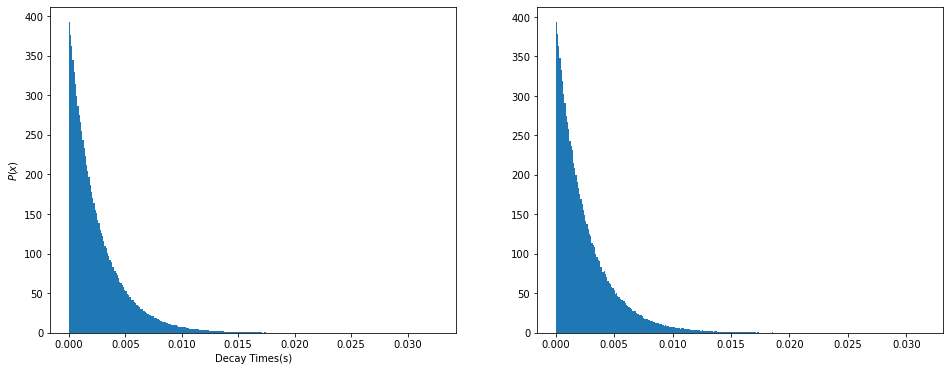

In [303]:
# analysis code
def time_plots(decay_times):
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    ax[0].hist(FinalDaught.decay_times, bins = 300, density = True)
    ax[0].set(xlabel = 'Decay Times(s)', ylabel = '$P(x)$', )
    ax[1].hist(decay_times, bins = 300, density = True)
    plt.show()
# plot the distribution of times, compare with initial - use kl divergence and give error

time_plots(decay_times)

## Part 8 - Discussion

In the markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained, and any conclusions. You are not expected to write more than 600-700 words, and you don't need to repeat information already given in the assignment.

 _Your discussion goes here_

In [304]:
# def part3plots(DaughterParticle, Tracking):
#     rx = Tracking.hits(DaughterParticle)[0]; ry = Tracking.hits(DaughterParticle)[1]
#     stations = [Tracking.z_stn1, Tracking.z_stn2, Tracking.z_stn3, Tracking.z_stn4]
#     zz = np.zeros([4,4])
#     fig = plt.figure(figsize = (20, 10))
#     ax = fig.add_subplot(111, projection = '3d')
    
#     colors = iter(plt.cm.Accent(np.linspace(0, 1, 4)))
#     for i in range(0, 4):
#         points = np.linspace(-1, 1, 4)
#         (xx, yy), zz = np.meshgrid(points, points), np.ones([4, 4])
#         zz[:] = stations[i]
#         ax.plot_wireframe(xx, zz, yy, color = next(colors))
#         ax.set_xlabel('x(m)')
#         ax.set_ylabel('z(m)')
#         ax.set_zlabel(' y(m)')
#     ax.view_init(15)
#     ax.set_ylim3d(10, 50)
    
#     ax.set_zlim3d(-1, 1)
    
#     ax.set_xlim3d(-1, 1)
    
    
#     ax.invert_xaxis()
    
